In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib

# Notebook 1 – Modelo No Paramétrico (Árbol de Decisión / Random Forest)

En este notebook se realiza:
1. Carga y exploración inicial de datos.
2. Generación de features geométricas.
3. División en train/test.
4. Entrenamiento con búsqueda de hiperparámetros.
5. Evaluación del modelo.
6. Visualización e interpretación de resultados.
7. Guardado del pipeline final.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from joblib import dump

# Modelos
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import HistGradientBoostingRegressor # El "XGBoost" de Sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import FunctionTransformer

# Geometría
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# Configuración
RANDOM_STATE = 42
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carga y exploración inicial

- Cargamos el dataset original.
- Exploramos dimensiones, tipos de datos y estadísticas básicas.
- Graficamos la distribución de la energía (target) y su relación con `qW`.

Filas originales: 7,277
Filas únicas tras eliminar duplicados: 2,737
        Total_Power           qW
count  2.737000e+03  2737.000000
mean   6.959157e+06     0.721995
std    1.998767e+05     0.020921
min    6.099480e+06     0.630000
25%    6.806309e+06     0.710000
50%    6.941249e+06     0.720000
75%    7.129514e+06     0.740000
max    7.364528e+06     0.760000


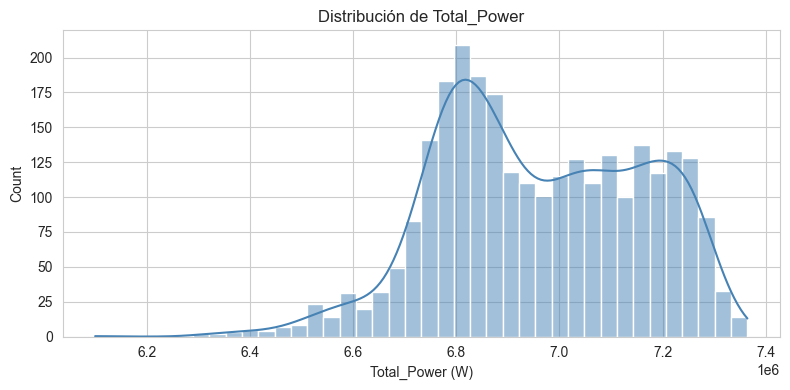

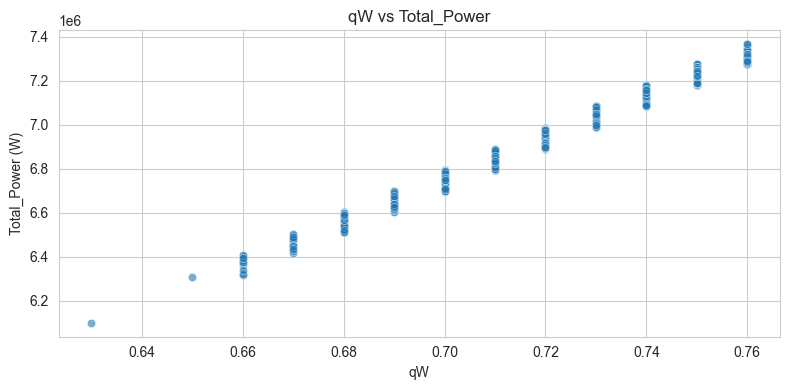

In [3]:
dataset_path = Path('dataset') / 'WEC_Perth_100.csv'
df_raw = pd.read_csv(dataset_path)
df = df_raw.drop_duplicates().reset_index(drop=True)
print(f'Filas originales: {len(df_raw):,}')
print(f'Filas únicas tras eliminar duplicados: {len(df):,}')
print(df[['Total_Power', 'qW']].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df['Total_Power'], bins=40, kde=True, color='steelblue')
plt.title('Distribución de Total_Power')
plt.xlabel('Total_Power (W)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(x=df['qW'], y=df['Total_Power'], alpha=0.6)
plt.title('qW vs Total_Power')
plt.xlabel('qW')
plt.ylabel('Total_Power (W)')
plt.tight_layout()
plt.show()


In [4]:
def canonical_sort(X_coords, Y_coords):
    """
    Reordena las boyas espacialmente (de menor a mayor X, y luego Y).
    Esto hace que la columna 1 siempre sea la boya más al 'Oeste'.
    """
    n_samples = X_coords.shape[0]
    n_buoys = X_coords.shape[1]
    
    X_sorted = np.zeros_like(X_coords)
    Y_sorted = np.zeros_like(Y_coords)
    
    for i in range(n_samples):
        # Obtenemos las coordenadas de este parque
        x_row = X_coords[i]
        y_row = Y_coords[i]
        
        # Índices que ordenarían las boyas por coordenada X
        # (Si hay empate en X, desempata por Y)
        sort_idx = np.lexsort((y_row, x_row)) 
        
        # Reordenamos
        X_sorted[i] = x_row[sort_idx]
        Y_sorted[i] = y_row[sort_idx]
        
    return X_sorted, Y_sorted

# Separamos coordenadas
x_cols = [f'X{i+1}' for i in range(100)]
y_cols = [f'Y{i+1}' for i in range(100)]
coords_x_raw = df[x_cols].to_numpy()
coords_y_raw = df[y_cols].to_numpy()

print("🔄 Aplicando Ordenamiento Canónico (Sorting)...")
coords_x, coords_y = canonical_sort(coords_x_raw, coords_y_raw)
print("✅ Boyas reordenadas geométricamente.")

🔄 Aplicando Ordenamiento Canónico (Sorting)...
✅ Boyas reordenadas geométricamente.


## 2. Ingeniería geométrica de features

A partir de las matrices de posiciones `X_mat` y `Y_mat`, se generan características relevantes que buscan representar geometría, densidad y distribución del arreglo. Estas features permiten caracterizar cada layout sin incluir información del target.

In [5]:
def extract_advanced_features(X_mat, Y_mat):
    n_samples = X_mat.shape[0]
    features_list = []
    
    for i in range(n_samples):
        layout = np.column_stack((X_mat[i], Y_mat[i]))
        
        # 1. Geometría Global
        centroid = layout.mean(axis=0)
        centered = layout - centroid
        hull = ConvexHull(layout)
        
        # Inercia (Dispersión direccional)
        Ixx = (centered[:, 1]**2).sum() # Dispersión en Y (frente de ola)
        Iyy = (centered[:, 0]**2).sum() # Dispersión en X (profundidad)
        
        # 2. Interacción (Potencial)
        dists = pdist(layout)
        interaction = (1.0 / (dists + 1e-6)).sum()
        
        # 3. Análisis de Filas (Front vs Back)
        # Como ya ordenamos por X, las primeras boyas son la "fila frontal" (reciben ola limpia)
        # y las últimas son la "fila trasera" (reciben sombra).
        front_row_x = X_mat[i, :10].mean() # Promedio X de las 10 primeras boyas
        back_row_x = X_mat[i, -10:].mean() # Promedio X de las 10 últimas
        depth_gradient = back_row_x - front_row_x
        
        # 4. Vecinos
        nbrs = NearestNeighbors(n_neighbors=2).fit(layout)
        nn_dists, _ = nbrs.kneighbors(layout)
        min_dist_avg = nn_dists[:, 1].mean() # Promedio de la distancia al vecino más cercano
        
        features_list.append({
            'hull_area': hull.volume,
            'density': 100 / hull.volume,
            'interaction_potential': interaction,
            'Ixx_spread_Y': Ixx, # Importante: qué tan ancho es el parque frente a la ola
            'Iyy_depth_X': Iyy,  # Importante: qué tan profundo es
            'shape_ratio': Ixx / (Iyy + 1e-6),
            'min_dist_avg': min_dist_avg,
            'depth_gradient': depth_gradient # Nueva feature basada en el ordenamiento
        })
        
    # Convertimos features a DataFrame
    df_feat = pd.DataFrame(features_list)
    
    # ⚠️ TRUCO DEL XGBOOST:
    # Añadimos también las coordenadas crudas ordenadas como features.
    # Como ahora X1 SIEMPRE es la boya del oeste, el modelo puede aprender posiciones exactas.
    df_coords = pd.DataFrame(X_mat, columns=[f'Sort_X{i}' for i in range(100)])
    df_coords_y = pd.DataFrame(Y_mat, columns=[f'Sort_Y{i}' for i in range(100)])
    
    # Concatenamos todo
    return pd.concat([df_feat, df_coords, df_coords_y], axis=1)

print("⚡ Generando Features Avanzadas + Coordenadas Ordenadas...")
X = extract_advanced_features(coords_x, coords_y)
y = df['Total_Power']

# Verificar que NO hay Data Leakage
if 'qW' in X.columns or 'Total_Power' in X.columns:
    raise ValueError("🚨 ALERTA: Data Leakage.")

print(f"✅ Input listo. Dimensiones: {X.shape}")

⚡ Generando Features Avanzadas + Coordenadas Ordenadas...
✅ Input listo. Dimensiones: (2737, 208)


## 3. División train/test

Se reserva un conjunto de test independiente para evaluar el desempeño real del modelo después de la validación cruzada interna. La semilla fija asegura reproducibilidad.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 2189 | Test: 548


## 4. Entrenamiento y bÃºsqueda de hiperparÃ¡metros

Entrenamos un HistGradientBoostingRegressor regulado y exploramos tasas de aprendizaje, profundidad, hojas y regularizaciÃ³n mediante validaciÃ³n cruzada para evitar sobreajuste.


In [7]:
# Pipeline
pipeline_hgb = Pipeline([
    # Opcional: ('scaler', StandardScaler()), 
    ('boost', HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        # Mantener early_stopping=True es crucial para evitar sobreajuste temporal
        early_stopping=True
    ))
])

# Grid Search Tuning - SEGUNDA RONDA (Ajustado para reducir Overfitting)
L2_OPT_MIN = 1.0  # Por ejemplo, si el mejor fue 5.0, empieza un poco antes
L2_OPT_MAX = 10.0 # Y termina un poco después

# Grid Search Tuning - TERCERA RONDA (Fine-Tuning de Convergencia)
param_grid_final = {
    # ⬇️ 1. Explorar un 'learning_rate' más lento para una mejor precisión
    'boost__learning_rate': [0.01, 0.03, 0.05],
    
    # 🔒 2. Fijar la profundidad y la hoja a valores que ya sabemos que controlan el overfitting
    # Ajusta estos valores si tus best_params_ previos fueron diferentes.
    'boost__max_depth': [6, 8], 
    'boost__min_samples_leaf': [75, 100], 
    
    # 🔍 3. Rango de regularización más fino alrededor del óptimo
    'boost__l2_regularization': [L2_OPT_MIN, 5.0, L2_OPT_MAX], 
    
    # Mantenemos las iteraciones y el estado aleatorio igual
    'boost__max_iter': [500] 
}

print("✨ Iniciando Fine-Tuning: Explorando bajas tasas de aprendizaje...")

grid_final = GridSearchCV(
    pipeline_hgb, # Usamos el mismo pipeline definido anteriormente
    param_grid_final, # Usamos la grilla de ajuste fino
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_final.fit(X_train, y_train)
best_model_final = grid_final.best_estimator_

print("✅ Fine-Tuning completado.")
print(f"🏆 Mejores parámetros finales: {grid_final.best_params_}")





✨ Iniciando Fine-Tuning: Explorando bajas tasas de aprendizaje...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Fine-Tuning completado.
🏆 Mejores parámetros finales: {'boost__l2_regularization': 5.0, 'boost__learning_rate': 0.05, 'boost__max_depth': 8, 'boost__max_iter': 500, 'boost__min_samples_leaf': 100}


## 5. Evaluación del modelo

Reportamos errores en train y test, además del R². Una buena generalización implica que el desempeño entre ambos conjuntos sea similar.

In [8]:
# Evaluación Final (Copiamos las métricas para comparación directa)
y_pred_train_final = best_model_final.predict(X_train)
y_pred_test_final = best_model_final.predict(X_test)

r2_train_final = r2_score(y_train, y_pred_train_final)
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
# LÍNEA CORREGIDA: Usar y_pred_train_final para la métrica de entrenamiento
mae_train_final = mean_absolute_error(y_train, y_pred_train_final) 

r2_test_final = r2_score(y_test, y_pred_test_final)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
mae_test_final = mean_absolute_error(y_test, y_pred_test_final)

print("📊 RESULTADOS FINALES (Modelo Fine-Tuned):")
print(f"--- Train Set ---")
print(f"R2 Score: {r2_train_final:.4f}")
print(f"RMSE:     {rmse_train_final:.0f}")
print(f"MAE:      {mae_train_final:.0f}")
print(f"--- Test Set ---")
print(f"R2 Score: {r2_test_final:.4f}")
print(f"RMSE:     {rmse_test_final:.0f}")
print(f"MAE:      {mae_test_final:.0f}")
print(f"📉 Brecha Final Overfitting: {abs(r2_train_final - r2_test_final):.4f}")

📊 RESULTADOS FINALES (Modelo Fine-Tuned):
--- Train Set ---
R2 Score: 0.9860
RMSE:     23579
MAE:      14867
--- Test Set ---
R2 Score: 0.9102
RMSE:     60675
MAE:      44482
📉 Brecha Final Overfitting: 0.0758


## 6. Visualización e interpretabilidad

Incluye gráficos de dispersión y análisis de importancia de variables para comprender qué características dominan las predicciones.

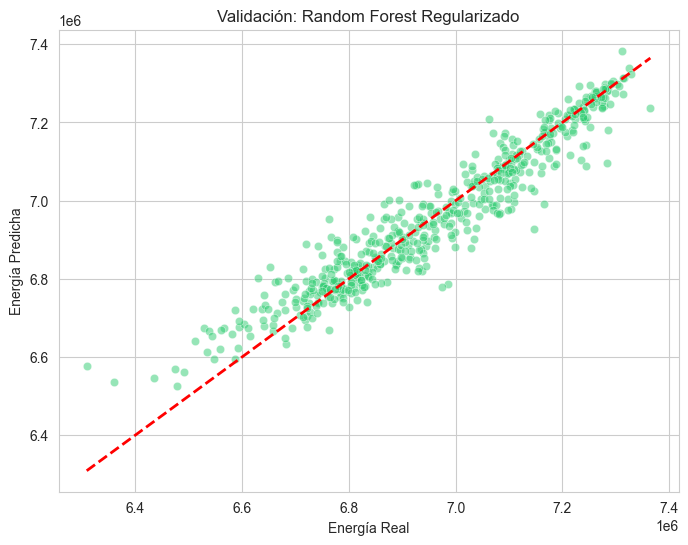

['models\\rf_physics_stable.joblib']

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test_final, alpha=0.5, color='#2ecc71')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Energía Real")
plt.ylabel("Energía Predicha")
plt.title("Validación: Random Forest Regularizado")
plt.show()

# Guardar
output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
dump(best_model_final, output_dir / 'rf_physics_stable.joblib')

## 7. Guardado del pipeline final

Persistimos el modelo entrenado junto con las transformaciones necesarias, permitiendo cargarlo en futuros experimentos sin necesidad de reentrenarlo.

In [10]:
output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
model_path = output_dir / 'decision_tree_pipeline_final.joblib'

dump(best_model_final, model_path)
print(f"💾 Modelo guardado exitosamente en: {model_path}")

💾 Modelo guardado exitosamente en: models\decision_tree_pipeline_final.joblib
